# L4: Multimodal Retrieval Augmented Generation (MM-RAG)

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

>how to leverage Weaviate and Google Gemini to carry out a simple multimodal RAG workflow.

```
    !pip install -U weaviate-client
    !pip install google-generativeai
```

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Setup
### Load environment variables and API keys

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

EMBEDDING_API_KEY = os.getenv("EMBEDDING_API_KEY")
GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")

> Note: learn more about [GOOGLE_API_KEY](https://ai.google.dev/) to run it locally.

### Connect to Weaviate

In [3]:
import weaviate

client = weaviate.connect_to_embedded(
    version="1.24.21",
    environment_variables={
        "ENABLE_MODULES": "backup-filesystem,multi2vec-palm",
        "BACKUP_FILESYSTEM_PATH": "/home/jovyan/work/L4/backups",
    },
    headers={
        "X-PALM-Api-Key": EMBEDDING_API_KEY,
    }
)

client.is_ready()

Started /home/jovyan/.cache/weaviate-embedded: process ID 236


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2025-04-15T18:33:58Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2025-04-15T18:33:58Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2025-04-15T18:33:58Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50050","time":"2025-04-15T18:33:58Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2025-04-15T18:33:58Z"}
/usr/local/lib/python3.11/site-packages/weaviate/warnings.py:130: DeprecationWarning: Dep005: You are using weaviate-client version 4.5.4. The latest version is 4.13.2.
         

True

{"action":"telemetry_push","level":"info","msg":"telemetry started","payload":"\u0026{MachineID:d4d820b6-7cd7-457e-8009-d0d8b1936f82 Type:INIT Version:1.24.21 NumObjects:0 OS:linux Arch:amd64 UsedModules:[]}","time":"2025-04-15T18:33:58Z"}


### Restore 13k+ prevectorized resources

In [4]:
client.collections.delete("Resources")

client.backup.restore(
    backup_id="resources-img-and-vid",
    include_collections="Resources",
    backend="filesystem"
)

# It can take a few seconds for the "Resources" collection to be ready.
# We add 5 seconds of sleep to make sure it is ready for the next cells to use.
import time
time.sleep(5)

{"action":"try_restore","backend":"filesystem","backup_id":"resources-img-and-vid","level":"info","msg":"","time":"2025-04-15T18:34:03Z","took":2545527}
{"action":"hnsw_prefill_cache_async","level":"info","msg":"not waiting for vector cache prefill, running in background","time":"2025-04-15T18:34:03Z","wait_for_cache_prefill":false}
{"level":"info","msg":"Completed loading shard resources_YR4XdMe3ODX3 in 8.861634ms","time":"2025-04-15T18:34:03Z"}
{"action":"restore","backup_id":"resources-img-and-vid","class":"Resources","level":"info","msg":"successfully restored","time":"2025-04-15T18:34:03Z"}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","msg":"backup restored successfully","time":"2025-04-15T18:34:03Z"}
{"action":"hnsw_vector_cache_prefill","count":16062,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2025-04-15T18:34:04Z","took":152162292}
{"action":"restore","backup_id":"resources-img-and-vid","level":"info","

### Preview data count

In [5]:
from weaviate.classes.aggregate import GroupByAggregate

resources = client.collections.get("Resources")

response = resources.aggregate.over_all(
    group_by=GroupByAggregate(prop="mediaType")
)

# print rounds names and the count for each
for group in response.groups:
    print(f"{group.grouped_by.value} count: {group.total_count}")

image count: 13394
video count: 200


## Multimodal RAG

### Step 1 – Retrieve content from the database with a query

In [6]:
from IPython.display import Image
from weaviate.classes.query import Filter

def retrieve_image(query):
    resources = client.collections.get("Resources")
# ============
    response = resources.query.near_text(
        query=query,
        filters=Filter.by_property("mediaType").equal("image"), # only return image objects
        return_properties=["path"],
        limit = 1,
    )
# ============
    result = response.objects[0].properties
    return result["path"] # Get the image path

### Run image retrieval

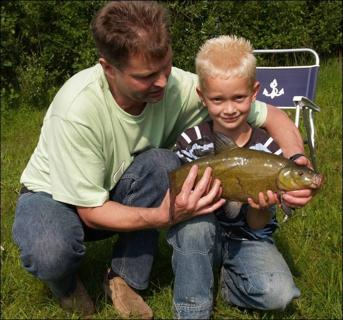

In [12]:
# Try with different queries to retreive an image
img_path = retrieve_image("fishing with my son")
display(Image(img_path))

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access Files and Helper Functions:</b> To access the files for this notebook, 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>


### Step 2 - Generate a description of the image

In [14]:
import google.generativeai as genai
from google.api_core.client_options import ClientOptions

# Set the Vision model key
genai.configure(
        api_key=GOOGLE_API_KEY,
        transport="rest",
        client_options=ClientOptions(
            api_endpoint=os.getenv("GOOGLE_API_BASE"),
        ),
)

>**Note:** Late 2024, the model `'gemini-pro-vision'` (originally shown in the video's notebook) has been replaced with `'gemini-1.5-flash'` for updates.
Additionally, due to this change, the parameter `stream=True` has now been set to `stream=False`.

In [15]:
# Helper function
import textwrap
import PIL.Image
from IPython.display import Markdown, Image

def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

def call_LMM(image_path: str, prompt: str) -> str:
    img = PIL.Image.open(image_path)

    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content([prompt, img], stream=False)
    response.resolve()

    return to_markdown(response.text)    

<p style="background-color:#cceecc; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> 🚨 <b>Different Run Results:</b> The output generated by AI models can vary with each execution due to their probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

### Run vision request

In [16]:
call_LMM(img_path, "Please describe this image in detail.")

> That's a lovely photo! Here's a description:
> 
> The image shows a man and a young boy proudly displaying a large tench fish they've caught. 
> 
> 
> Here's a breakdown of the details:
> 
> * **The People:** A middle-aged man with short, light brown hair is crouched down, his arm around a younger boy with short, blond hair. The man is wearing a light green t-shirt and blue jeans, and brown shoes. The boy is also wearing blue jeans, and a dark-colored, possibly striped, shirt. Both have happy expressions.
> 
> * **The Fish:** The tench is substantial in size, olive-green in color, and held gently by both the man and boy. It's the clear focal point of the image.
> 
> * **The Setting:** The background is softly blurred, but shows lush green vegetation, suggesting a park or garden setting near a body of water where the fishing took place. A portion of a dark blue folding camping chair with a nautical anchor design is visible in the upper right corner. The ground is grassy.
> 
> * **Overall:** The picture conveys a feeling of warmth, accomplishment, and the joy of a shared outdoor experience between a father and son. The lighting is natural and bright, suggesting a sunny day. The overall composition is informal and candid, capturing a genuine moment.


> Note: Please be aware that the output from the previous cell may differ from what is shown in the video. This variation is normal and should not cause concern.

## All together

In [17]:
def mm_rag(query):
    # Step 1 - retrieve an image – Weaviate
    SOURCE_IMAGE = retrieve_image(query)
    display(Image(SOURCE_IMAGE))
#===========

    # Step 2 - generate a description - GPT4
    description = call_LMM(SOURCE_IMAGE, "Please describe this image in detail.")
    return description

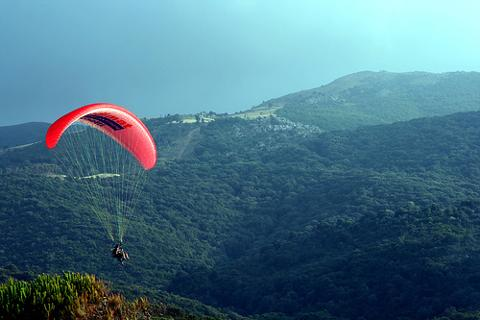

> Here's a description of the image:
> 
> Eye-level view of a red paraglider soaring over a vast, mountainous landscape. 
> 
> 
> Here's a breakdown of the details:
> 
> * **The Paraglider:** A vibrant red paraglider dominates the mid-ground. It's fully inflated and appears to be carrying two people, though they are small and indistinct from this distance. The lines connecting the paraglider to the harness are clearly visible.
> 
> * **The Landscape:** The background is a sweeping panorama of rolling hills and mountains covered in dense, dark green forest. The mountains are softly rounded, indicating a possibly Mediterranean or similar climate.  The far-off hills are lighter in color, suggesting a hazy atmosphere or distance. A lighter-colored area, possibly a clearing or field, is visible on one of the mid-range hills.
> 
> * **The Foreground:** The foreground shows a small portion of scrubby vegetation on a hillside, suggesting a somewhat rugged, natural environment.
> 
> * **The Sky:** The sky is a pale, light blue, almost washed-out, suggesting an overcast day or soft, diffused light. There are no harsh shadows.
> 
> The overall impression is one of serenity and freedom, with the paraglider adding a sense of adventure to the tranquil landscape. The color palette is predominantly greens and blues, with the red of the paraglider providing a sharp contrast. The image has a peaceful and somewhat romantic feel.


In [18]:
# Call mm_rag function
mm_rag("paragliding through the mountains")

In [ ]:
# Remember to close the weaviate instance
client.close()

### Try it yourself! 

Run the cells above selecting another image from the database and generate a description for it!